In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
from schedulers import LinearScheduler,CosineScheduler
from unet import UNetTimed, UNetTimedWithVAEConditioned
from schedulers import DDPM
from schedulers import DDIMSampler
from vae import VAE


mnist_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


In [10]:
vae_model = VAE(latent_dim=64)
vae_model.load_state_dict(torch.load('vae_model.pth'))
vae_model.eval()

for param in vae_model.parameters():
    param.requires_grad = False

unet = UNetTimedWithVAEConditioned(vae_model, use_condition=True)

# vae_model.encoder(torch.randn(1, 1, 28, 28))
# unet(torch.randn(1, 1, 28, 28), torch.randint(0, 1000, (1,)))


/tmp/ipykernel_61445/828656351.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model.load_state_dict(torch.load('vae_model.pth'))


In [11]:
# latent_image = unet.encode_vae(torch.randn(1, 1, 28, 28))
# denoised_image = unet(latent_image, torch.randint(0, 1000, (1,)))

# unet.decode_vae(denoised_image)

In [18]:
# Create DataLoader
batch_size = 128
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer and loss function
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
mse_loss = torch.nn.MSELoss()

# Training hyperparameters
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device)

# DDPM instance
ddpm = DDPM(0.001, 0.2, 1000)
unconditional_prob = 0.2

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        latent_images = unet.encode_vae(images)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Generate random noise
        noise = torch.randn_like(latent_images).to(device)
        use_condition = torch.rand(labels.size()) < unconditional_prob
        condition = torch.where(use_condition, torch.zeros_like(labels)-1, labels)
        condition = condition.to(device)
        
        # Generate random timesteps
        batch_size = latent_images.shape[0]
        timesteps = torch.randint(0, ddpm.max_timestep, (batch_size,), device=device)
        
        # Add noise to images according to timesteps
        noised_images = ddpm.add_noise(latent_images, timesteps, noise)
        
        # Predict noise
        predicted_noise = unet(noised_images, timesteps, condition)
        
        # Calculate loss
        loss = mse_loss(predicted_noise, noise)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}')
    
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch} | Average Loss: {avg_loss:.4f}')
    
    # Optional: Save checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'latent_ddpm_checkpoint_epoch_{epoch+1}.pt')

Epoch 0 | Batch 0 | Loss: 0.1600
Epoch 0 | Batch 100 | Loss: 0.1145
Epoch 0 | Batch 200 | Loss: 0.1766
Epoch 0 | Batch 300 | Loss: 0.1536
Epoch 0 | Batch 400 | Loss: 0.1346
Epoch 0 | Average Loss: 0.1459
Epoch 1 | Batch 0 | Loss: 0.1494
Epoch 1 | Batch 100 | Loss: 0.2015
Epoch 1 | Batch 200 | Loss: 0.1142
Epoch 1 | Batch 300 | Loss: 0.1447
Epoch 1 | Batch 400 | Loss: 0.1751
Epoch 1 | Average Loss: 0.1496
Epoch 2 | Batch 0 | Loss: 0.1533
Epoch 2 | Batch 100 | Loss: 0.1393
Epoch 2 | Batch 200 | Loss: 0.1699
Epoch 2 | Batch 300 | Loss: 0.1395
Epoch 2 | Batch 400 | Loss: 0.1634
Epoch 2 | Average Loss: 0.1461
Epoch 3 | Batch 0 | Loss: 0.2022
Epoch 3 | Batch 100 | Loss: 0.1707
Epoch 3 | Batch 200 | Loss: 0.0939
Epoch 3 | Batch 300 | Loss: 0.1908
Epoch 3 | Batch 400 | Loss: 0.1356
Epoch 3 | Average Loss: 0.1478
Epoch 4 | Batch 0 | Loss: 0.1452
Epoch 4 | Batch 100 | Loss: 0.1881
Epoch 4 | Batch 200 | Loss: 0.1503
Epoch 4 | Batch 300 | Loss: 0.1420
Epoch 4 | Batch 400 | Loss: 0.1870
Epoch 4 | A

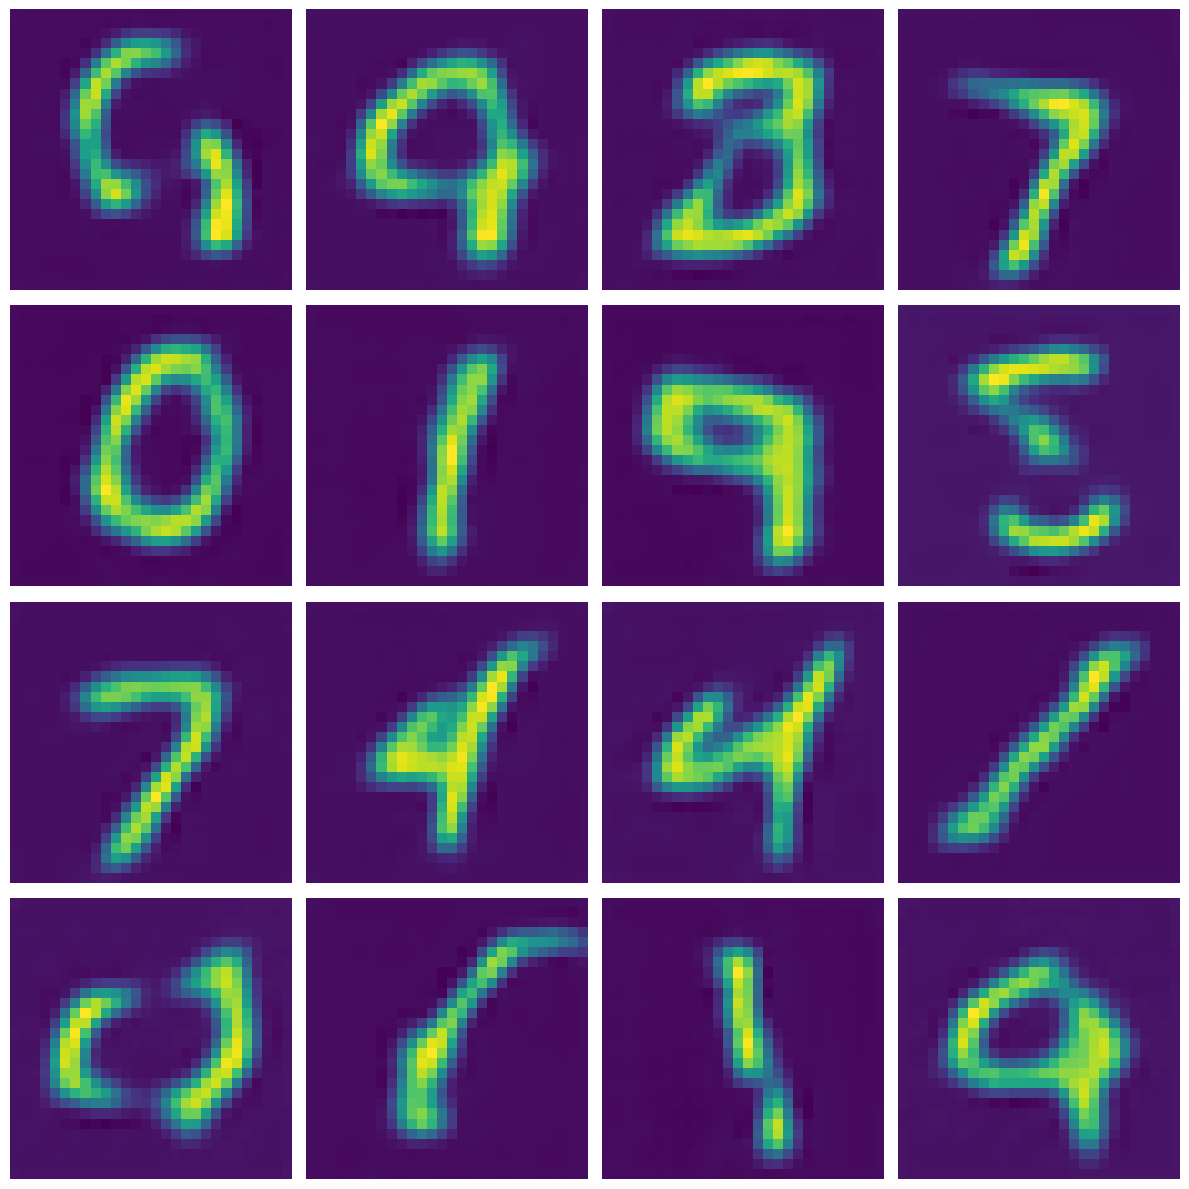

In [19]:
from schedulers import DDIMSampler
sampler = DDIMSampler(0.001, 0.2, 1000)
sampled_latent_images = sampler.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=150 # Can use fewer steps than training
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

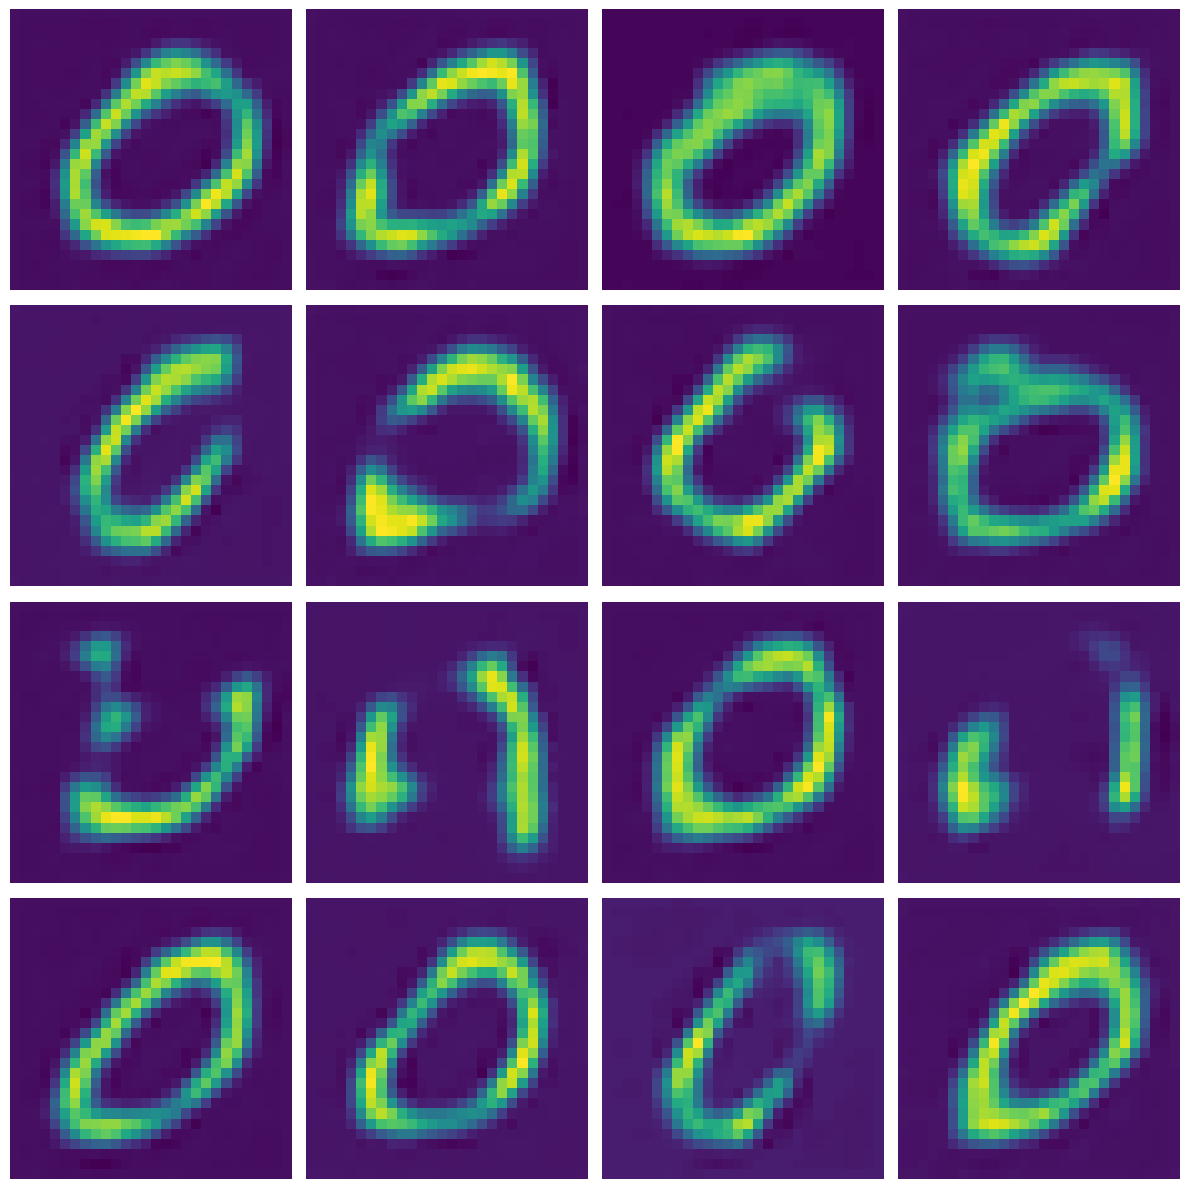

In [17]:
from schedulers import DDIMSampler
sampler = DDIMSampler(0.001, 0.2, 1000)
sampled_latent_images = sampler.sample(
    model=unet,
    n_samples=16,
    img_size=(1, 8, 8),  # For MNIST
    device=device,
    steps=100, # Can use fewer steps than training
    condition = torch.LongTensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
)


# Create a figure with subplots
plt.figure(figsize=(12, 12))

# Plot each sample
for i in range(16):
    plt.subplot(4, 4, i + 1)
    # Remove channel dimension and move tensor to CPU
    img = unet.decode_vae(sampled_latent_images[i]).cpu().numpy()[0,0]
    # Plot image
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()